### 0. Import Depedencies

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.keras.models import Sequential

### 1. Plot Styles

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

### 2. Inspect Data

In [14]:
train_data_dir = rf'{os.getcwd()}/data/2750'

In [15]:
data = {}
img_height, img_width = 0, 0
for path, dirs, files in os.walk(train_data_dir):
    dir_name = path.split('/')[-1]
    first_file = files[0]
    file_name, file_ext = first_file.split('.')
    if file_ext == 'jpg':
        image = Image.open(f'{path}/{first_file}')
        img_width, img_height = image.size
        data[dir_name] = {'count': len(files), 'height': img_height, 'width': img_width}

In [16]:
df = pd.DataFrame.from_dict(data, orient='index')
print(df.head(10))

      count  height  width
2750  27000      64     64


### 3. Create training, validation and testing dataset

In [17]:
batch_size = 32

In [21]:
train_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 26999 files belonging to 10 classes.
Using 21600 files for training.


In [22]:
validation_dataset = image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 26999 files belonging to 10 classes.
Using 5399 files for validation.


### 4. Inspect Tensorflow training dataset

In [23]:
# Get class names and number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f'number of classes: {num_classes}', class_names)

number of classes: 10 ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [24]:
# Retrieve a single batch of 32 images.
image_batch, label_batch = next(iter(train_dataset))

In [26]:
print(image_batch.shape)
print(label_batch.shape)

(32, 64, 64, 3)
(32,)


In [27]:
# Check image value range
first_image = image_batch[0].numpy().astype("uint8")
print(np.min(first_image), np.max(first_image))

88 192


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


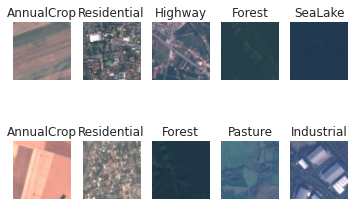

In [28]:
# Visualize 10 images from dataset
plt.figure()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    image = image_batch[i].numpy().astype("uint8")
    plt.imshow(image)
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.show()

### 5. Cache and prefetch for computational efficiency

In [29]:
# Dataset.prefetch overlaps data preprocessing and model execution while training
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [30]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
# Rescale image values into a range of [0,1]
rescaling_layer = layers.experimental.preprocessing.Rescaling(
    scale=1. / 255,
    input_shape=(img_height, img_width, 3)
)

In [32]:
# rescale data outside of model
rescaled_ds = train_dataset.map(lambda x, y: (rescaling_layer(x), y))
image_batch, labels_batch = next(iter(rescaled_ds))
first_image = image_batch[0].numpy().astype("float32")
print(np.min(first_image), np.max(first_image))

0.098039225 0.89019614


### 6. Create Training Model

In [33]:
# Define data augmentation layer

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [40]:
# Build a Tensorflow Sequential Conventional Neural Network
model = Sequential([

    # layer 1 - preprocessing layer with convolution and max pooling
    rescaling_layer,
    layers.Conv2D(filters=8, kernel_size=3, padding='same',
                  activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 2 - convolutional layer and max pooling
    layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 3 - convolutional layer and max pooling
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),

    # layer 4 - convolutional layer and max pooling
    layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    layers.Dropout(rate=0.1),
    layers.Flatten(),

    # layer 5 - dense fully connected layer
    layers.Dense(units=128, activation='relu'),

    # layer 6 - output dense layer
    layers.Dense(num_classes)
])

In [41]:
# Compile tensorflow sequential CNN model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
epochs = 5
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/5
675/675 [==============================] - 44s 65ms/step - loss: 0.8279 - accuracy: 0.6938 - val_loss: 0.6897 - val_accuracy: 0.7505
Epoch 2/5
675/675 [==============================] - 40s 59ms/step - loss: 0.7221 - accuracy: 0.7359 - val_loss: 0.8856 - val_accuracy: 0.6777
Epoch 3/5
675/675 [==============================] - 40s 59ms/step - loss: 0.6399 - accuracy: 0.7683 - val_loss: 0.5596 - val_accuracy: 0.7957
Epoch 4/5
675/675 [==============================] - 41s 61ms/step - loss: 0.5795 - accuracy: 0.7927 - val_loss: 0.5094 - val_accuracy: 0.8192
Epoch 5/5
675/675 [==============================] - 40s 59ms/step - loss: 0.5411 - accuracy: 0.8062 - val_loss: 0.5241 - val_accuracy: 0.8124


In [44]:
# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_13 (ModuleWra (None, 64, 64, 3)         0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 64, 64, 8)         224       
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 32, 32, 8)         0         
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 32, 32, 16)        1168      
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 16, 16, 16)        0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 16, 16, 32)        4640      
_________________________________________________________________
module_wrapper_19 (ModuleWra (None, 8, 8, 32)         

In [45]:
model.save(f'{os.getcwd()}/land_cover_model')

INFO:tensorflow:Assets written to: D:\Python Projects\Landcover_CNN/land_cover_model\assets


INFO:tensorflow:Assets written to: D:\Python Projects\Landcover_CNN/land_cover_model\assets


### 7. Plot Performance

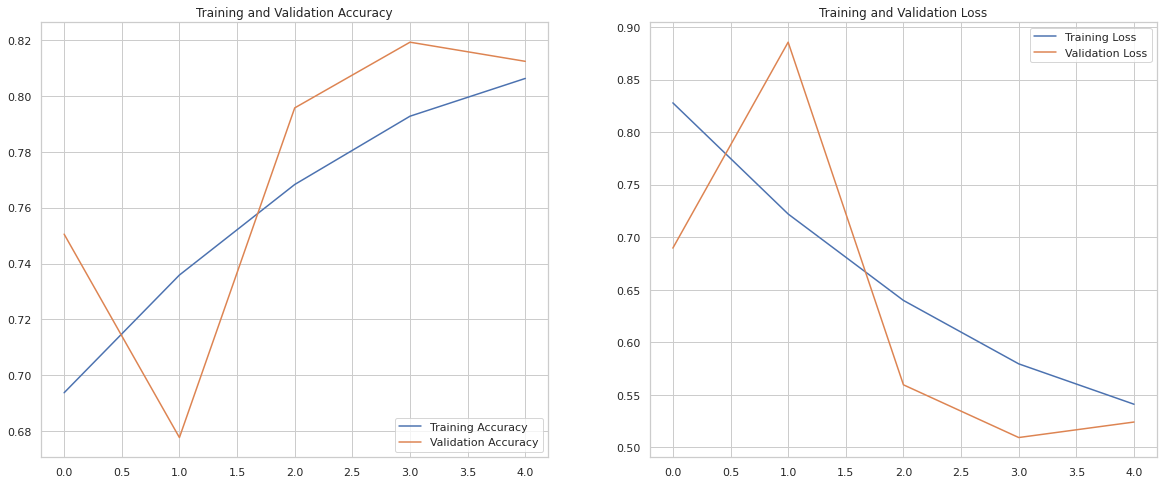

In [49]:
# visualize training metrics

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()